# Random Oversampling & Undersampling

This notebook implements 

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boundaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Import resampling methods to deal with imbalanced data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Import functions to make decision trees
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Import functions to help with training/testing endeavors and evaluate performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## The Data

The model will be trained using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


## Decision tree with imbalanced classes

In [3]:
# Data preparation step
X = hawks[["Wing", "Tail"]].to_numpy()
y = hawks["Species"].to_numpy()

# Code the species names numerically for to make decision tree analysis easier
species_nums = {"RT" : 0, "CH" : 1, "SS" : 2}
y_int = np.array(list(map(lambda i : species_nums[i], y)))

X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.20, random_state=1)

In [4]:
unique, counts = np.unique(y_train, return_counts = True)
train_counts = dict(zip(unique, counts))
print("Counts in the training set:", train_counts)

Counts in the training set: {0: 461, 1: 56, 2: 195}


In [5]:
unique, counts = np.unique(y_test, return_counts = True)
print("Counts in the testing set:", dict(zip(unique, counts)))

Counts in the testing set: {0: 106, 1: 13, 2: 60}


In [6]:
decision_tree = DecisionTreeClassifier(max_depth=6, random_state=42)
decision_tree.fit(X_train, y_train)

# Training accuracy
decision_tree.score(X_train, y_train)

0.9943820224719101

In [7]:
# Obtain predicted values on the testing data
y_pred = decision_tree.predict(X_test)

#Checking model performance with classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       106
           1       0.73      0.62      0.67        13
           2       0.98      0.95      0.97        60

    accuracy                           0.95       179
   macro avg       0.89      0.85      0.87       179
weighted avg       0.95      0.95      0.95       179



In [8]:
def plot_hawk_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    # Obtain confusion matrix
    cf_matrix = confusion_matrix(y_actual, y_pred)

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix - Decision Tree\n', fontsize = 14)
    ax.set_xlabel("Predicted Label", fontsize = 12)
    ax.set_xticklabels(["RT", "CH", "SS"])
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_yticklabels(["RT", "CH", "SS"], rotation = 0)

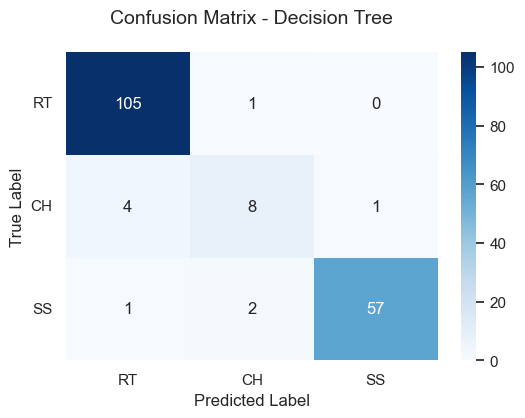

In [9]:
plot_hawk_confusion_matrix(y_test, y_pred)
plt.show()

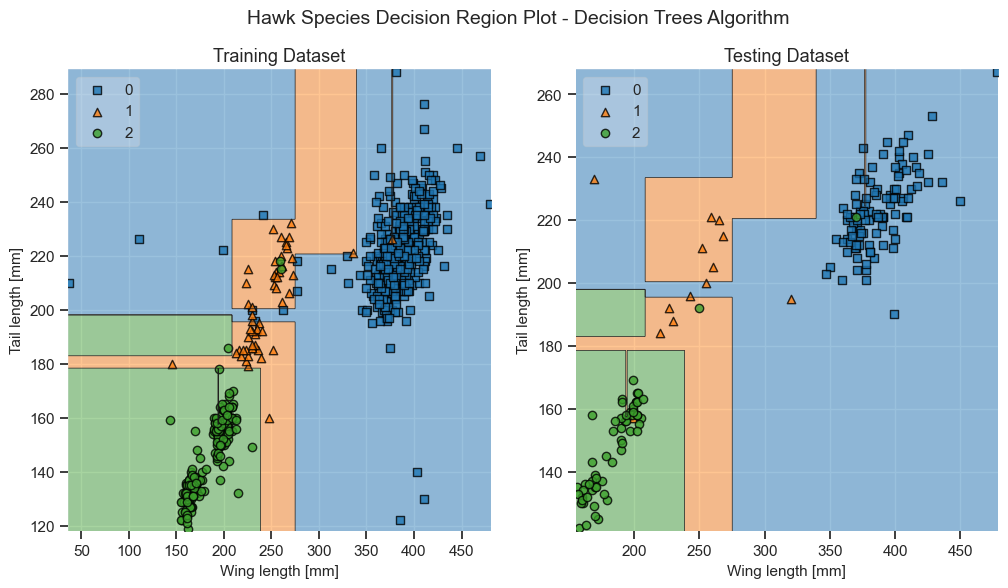

In [10]:
# Plot the training and testing observations with decision regions overlaid
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle("Hawk Species Decision Region Plot - Decision Trees Algorithm", fontsize = 14)
fig = plot_decision_regions(X_train, y_train, clf = decision_tree, ax = axes[0], legend = 2)
axes[0].set_title("Training Dataset", fontsize = 13)
axes[0].set_xlabel("Wing length [mm]", fontsize = 11)
axes[0].set_ylabel("Tail length [mm]", fontsize = 11)

fig = plot_decision_regions(X_test, y_test, clf = decision_tree, ax = axes[1], legend = 2)
axes[1].set_title("Testing Dataset", fontsize = 13)
axes[1].set_xlabel("Wing length [mm]", fontsize = 11)
axes[1].set_ylabel("Tail length [mm]", fontsize = 11)
plt.show()

## Random undersampling: undersampling the majority class

Because the dataset is unbalanced, I'm going to try and fit models using a more balanced ratio to see if that changes anything. First, I am going to undersample the majority class, meaning reducing the amount of zeroes in the training set. I only undersample the training set instead of the full data as it is generally recommended to in order to avoid information leakage and prevent overfitting. I will also only use the 3 features from feature selection, since this will generate the simpler model without much change in performance as found previously.

Following the undersampling, I will fit a model for 2 ensemble methods: random forests and boosting. Ensemble methods have more robust properties for unbalanced data, so that is why I will focus on them. It would be worth examining more of the previous models too, however.

In [11]:
rus = RandomUnderSampler(random_state = 42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print("Original training observations count:", len(y_train))
print("Undersampling training observations count:", len(y_rus))

Original training observations count: 712
Undersampling training observations count: 168


In [12]:
print("Counts in the training set:", train_counts)
# Stroke values distribution after undersampling majority of 0s
unique, counts = np.unique(y_rus, return_counts = True)
print("Counts in undersampled set:", dict(zip(unique, counts)))

Counts in the training set: {0: 461, 1: 56, 2: 195}
Counts in undersampled set: {0: 56, 1: 56, 2: 56}


In [13]:
decision_tree_rus = DecisionTreeClassifier(max_depth=6, random_state=42)
decision_tree_rus.fit(X_rus, y_rus)

# Training accuracy
decision_tree.score(X_rus, y_rus)

0.9880952380952381

In [14]:
# Obtain predicted values on the testing data
y_pred_rus = decision_tree_rus.predict(X_test)

#Checking model performance with classification report
print(classification_report(y_test, y_pred_rus))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       106
           1       0.57      0.92      0.71        13
           2       0.98      0.88      0.93        60

    accuracy                           0.94       179
   macro avg       0.85      0.93      0.87       179
weighted avg       0.96      0.94      0.94       179



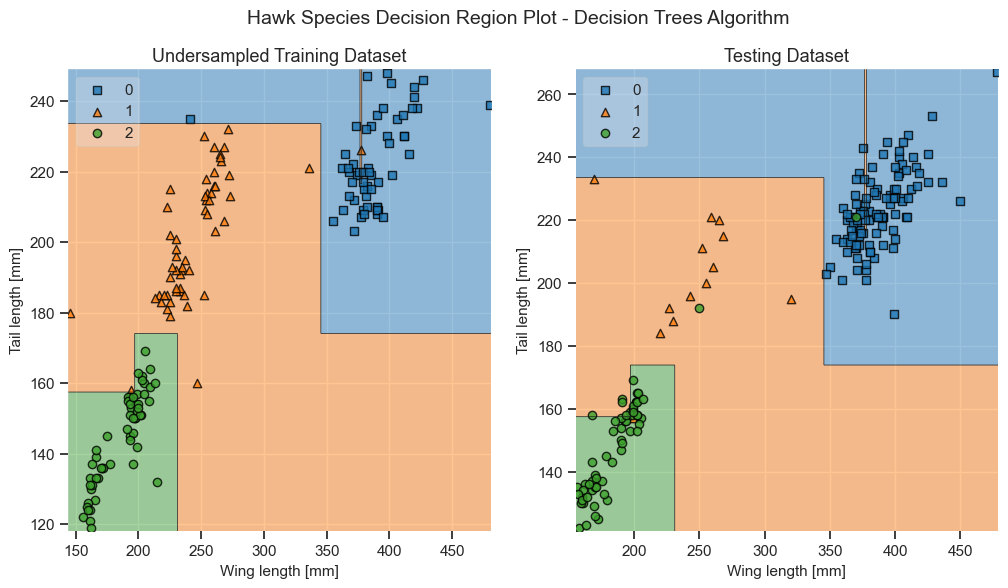

In [15]:
# Plot the training and testing observations with decision regions overlaid
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle("Hawk Species Decision Region Plot - Decision Trees Algorithm", fontsize = 14)
fig = plot_decision_regions(X_rus, y_rus, clf = decision_tree_rus, ax = axes[0], legend = 2)
axes[0].set_title("Undersampled Training Dataset", fontsize = 13)
axes[0].set_xlabel("Wing length [mm]", fontsize = 11)
axes[0].set_ylabel("Tail length [mm]", fontsize = 11)

fig = plot_decision_regions(X_test, y_test, clf = decision_tree_rus, ax = axes[1], legend = 2)
axes[1].set_title("Testing Dataset", fontsize = 13)
axes[1].set_xlabel("Wing length [mm]", fontsize = 11)
axes[1].set_ylabel("Tail length [mm]", fontsize = 11)
plt.show()

## Random oversampling: oversampling the minority class

In [16]:
ros = RandomOverSampler(random_state = 42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

print("Original training observations count:", len(y_train))
print("Oversampling training observations count:", len(y_ros))

Original training observations count: 712
Oversampling training observations count: 1383


In [17]:
print("Counts in the training set:", train_counts)
# Stroke values distribution after oversampling minority of 1s
unique, counts = np.unique(y_ros, return_counts = True)
print("Counts in oversampled set:", dict(zip(unique, counts)))

Counts in the training set: {0: 461, 1: 56, 2: 195}
Counts in oversampled set: {0: 461, 1: 461, 2: 461}


In [18]:
decision_tree_ros = DecisionTreeClassifier(max_depth=6, random_state=42)
decision_tree_ros.fit(X_ros, y_ros)

# Training accuracy
decision_tree_ros.score(X_ros, y_ros)

0.9942154736080984

In [19]:
# Obtain predicted values on the testing data
y_pred_ros = decision_tree_ros.predict(X_test)

#Checking model performance with classification report
print(classification_report(y_test, y_pred_ros))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       106
           1       0.77      0.77      0.77        13
           2       0.97      0.95      0.96        60

    accuracy                           0.96       179
   macro avg       0.91      0.90      0.90       179
weighted avg       0.96      0.96      0.96       179



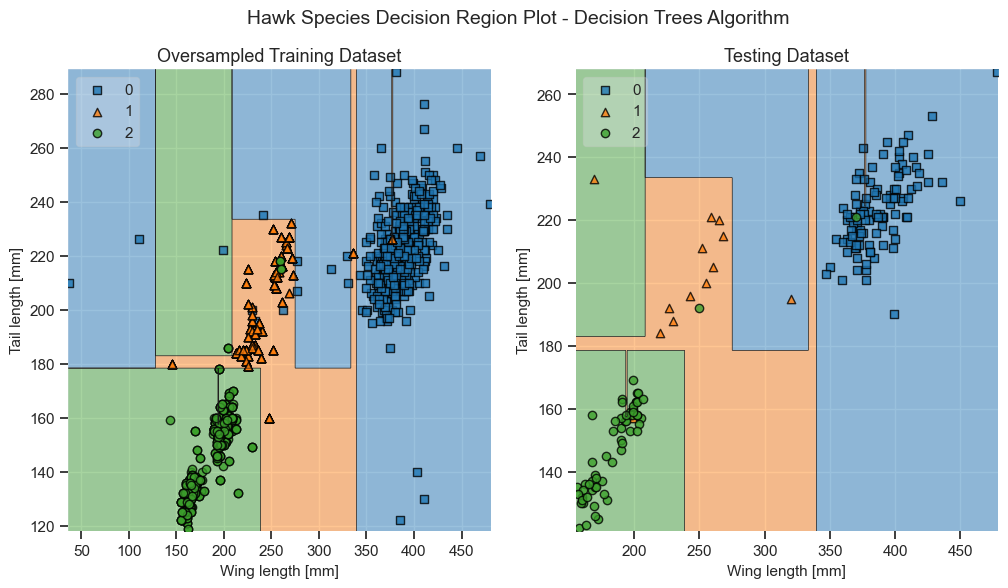

In [20]:
# Plot the training and testing observations with decision regions overlaid
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle("Hawk Species Decision Region Plot - Decision Trees Algorithm", fontsize = 14)
fig = plot_decision_regions(X_ros, y_ros, clf = decision_tree_ros, ax = axes[0], legend = 2)
axes[0].set_title("Oversampled Training Dataset", fontsize = 13)
axes[0].set_xlabel("Wing length [mm]", fontsize = 11)
axes[0].set_ylabel("Tail length [mm]", fontsize = 11)

fig = plot_decision_regions(X_test, y_test, clf = decision_tree_ros, ax = axes[1], legend = 2)
axes[1].set_title("Testing Dataset", fontsize = 13)
axes[1].set_xlabel("Wing length [mm]", fontsize = 11)
axes[1].set_ylabel("Tail length [mm]", fontsize = 11)
plt.show()